In [1]:
import son_main_script as soon
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from pymoo.indicators.hv import Hypervolume
import json
import os
import plotly.graph_objects as go
import numpy as np

In [2]:
################################
# prepare dataset for single experiment
# load results form all runs for one experiment
# save averaged data sets to result directory
#################################
network_name = "hetNet2"
configuration_name ="foot40_resetting_20"
results_directory = "./datastore/{network_name}/{configuration_name}/".format(network_name=network_name, configuration_name= configuration_name)

## TODO find a better way to automatically create np.array in correct shape

shape = (0,2400)

## create objective list
objective_1_list = np.empty(shape)
objective_2_list = np.empty(shape)
time_and_frames_list = np.empty(shape)
directory_contents = os.listdir(results_directory)
for item in directory_contents:
    if "objectives_result" in item:
        with open(results_directory + "/" + item, mode="r",encoding="utf-8") as openfile:
            result_dict_object = np.array(json.load(openfile))
            objective_1_list = np.append(np.array([result_dict_object[:, 2]]), objective_1_list, axis=0)
            objective_2_list = np.append(np.array([result_dict_object[:, 3]]), objective_2_list, axis=0)
            time_and_frames_list = result_dict_object[:, 0:2]


normalize_factor_1 = (objective_1_list.max() - objective_1_list.min()) if (objective_1_list.max() - objective_1_list.min()) != 0 else objective_1_list.max()
normalize_factor_2 = (objective_2_list.max() - objective_2_list.min()) if (objective_2_list.max() - objective_2_list.min()) != 0 else objective_2_list.max()
## normalize objectives
objective_1_normalized_list = np.array((objective_1_list - objective_1_list.min()) / normalize_factor_1)
objective_2_normalized_list = np.array((objective_2_list - objective_2_list.min()) / normalize_factor_2)

## find ideal and nadir points over all runs for every negative objective due to minimization
negative_normalized_objective_list_1 = objective_1_normalized_list *-1
negative_normalized_objective_list_2 = objective_2_normalized_list *-1
approx_ideal = np.append(negative_normalized_objective_list_1, negative_normalized_objective_list_2, axis=0).min()
approx_nadir = np.append(negative_normalized_objective_list_1, negative_normalized_objective_list_2, axis=0).max()


hv = Hypervolume(ref_point=np.array([1.1, 1.1]),
                     norm_ref_point=False,
                     zero_to_one=False,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hypervolume_list = np.empty(shape)
objective_1_avrg_list = np.empty(0)
objective_2_avrg_list = np.empty(0)
objective_1_normalized_avrg_list = np.empty(0)
objective_2_normalized_avrg_list = np.empty(0)

for run_index, run_values in enumerate(objective_1_normalized_list):
    hv_run_values = np.empty(0)
    for time_step_index, _ in enumerate(run_values):
        
        hv_value = hv(np.array([negative_normalized_objective_list_1[run_index][time_step_index],negative_normalized_objective_list_2[run_index][time_step_index]]))
        if hv_value is not None:
            hv_run_values = np.append(hv_run_values, hv_value)


    hypervolume_list = np.append(hypervolume_list, np.array([hv_run_values]), axis=0)

    hypervolume_avrg_list = np.average(hypervolume_list, axis=0)
    objective_1_avrg_list =np.average(objective_1_list, axis=0)
    objective_2_avrg_list = np.average(objective_2_list, axis=0)

    objective_1_normalized_avrg_list = np.average(objective_1_normalized_list, axis=0)
    objective_2_normalized_avrg_list = np.average(objective_2_normalized_list, axis=0)

## save averaged objective set in current directory
with open(results_directory + "/averaged_objectives.json", "w") as outfile:
    dump_array = np.array([time_and_frames_list[:,0], time_and_frames_list[:, 1], objective_1_avrg_list, objective_2_avrg_list])
    dump_array= np.transpose(dump_array).tolist()
    json.dump(dump_array, outfile)




In [ ]:
##################
# plots for single experiment which is defined in above cell
##################

## hyper volume plot
from tokenize import group


fig1 = go.Figure()
fig1.update_layout(
    title=f"hypervolume averaged ({configuration_name})",
    xaxis_title="time in s",
    yaxis_title="Hypervolume")

## add averaged values
fig1.add_trace(
    go.Scatter(
        x=time_and_frames_list[:, 1],
        y=hypervolume_avrg_list,
        mode='lines+markers',
        name= "averaged set",
        line={"width": 3, "color": "red"}
        ))

## add run values
for index, value in enumerate(hypervolume_list):
    fig1.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=value,
            mode='lines+markers',
            name= f"run_{str(index+1)}",
            opacity=0.25
        ))


## objective volume plot
fig2 = go.Figure()

fig2.update_layout(
    title= f"objectives averaged over all runs ({configuration_name})",
    xaxis_title="time in s",
    yaxis_title="objectives",
    legend_title="dataset",
    )

fig2.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_1_avrg_list,
            name="energy_efficiency" + "_" +configuration_name,
            mode='lines+markers',
            line={"width": 3, "color": "red"},
            legendgroup="1"
        ))
fig2.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_2_avrg_list,
            name="avrg_dl_datarate" + "_"+ configuration_name,
            mode='lines+markers',
            line={"width": 3, "color": "orange"},
            legendgroup="2"
        ))
for index, _ in enumerate(objective_1_list):
    fig2.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_1_list[index],
            name="run" + "_" +str(index+1),
            mode='lines+markers',
            line={"color": "red"},
            opacity=0.25,
            legendgroup="1"
        ))
    fig2.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_2_list[index],
            name="run" + "_"+ str(index+1),
            mode='lines+markers',
             line={"color": "orange"},
             opacity=0.25,
             legendgroup="2"
        ))


## normalized objective plot
fig3 = go.Figure()

fig3.update_layout(
    title= f"normalized objectives averaged over all runs ({configuration_name})",
    xaxis_title="time in s",
    yaxis_title="normalized objectives")

fig3.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_1_normalized_avrg_list,
            name="average" ,
            mode='lines+markers',
            line={"width": 3, "color": "red"},
            legendgroup="energy_efficiency",
            legendgrouptitle_text="energy_efficiency"
        ))
fig3.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_2_normalized_avrg_list,
            name="average",
            mode='lines+markers',
            line={"width": 3, "color": "orange"},
            legendgroup="avrg_dl_datarate",
            legendgrouptitle_text="avrg_dl_datarate"
        ),)
for index, _ in enumerate(objective_1_list):
    fig3.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_1_normalized_list[index],
            name="run" + "_" +str(index+1),
            mode='lines+markers',
            line={"color": "red"},
            opacity=0.25,
            legendgroup="energy_efficiency",
            legendgrouptitle_text="energy_efficiency"
        ))
    fig3.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_2_normalized_list[index],
            name="run" + "_"+ str(index+1),
            mode='lines+markers',
            line={"color": "orange"},
            opacity=0.25,
            legendgroup="avrg_dl_datarate",
            legendgrouptitle_text="avrg_dl_datarate"
        ))

fig1.show()
fig2.show()
fig3.show()

In [4]:
############################
## prepare datasets for comparison of several experiments (same network, differing param configs)
############################


## beachte, dass alle Datensätze gleiche Dimensionalität haben müssen


network_name = "hetNet2"
configuration_names = ["foot40_resetting_20", "foot40_greedy", "foot40_noresetting"]
# configuration_names = ["ee_nomovement_evo", "ee_nomovement_greedy"]

## create objective list by combining datasets of all experiments
objective_1_list = np.empty(shape)
objective_2_list = np.empty(shape)

for _, configuration_name in enumerate(configuration_names):
    results_directory = "./datastore/{network_name}/{configuration_name}/".format(network_name=network_name, configuration_name= configuration_name)

    with open(results_directory + "/" + "averaged_objectives.json", mode="r",encoding="utf-8") as openfile:
        result_dict_object = np.array(json.load(openfile))
        objective_1_list = np.append(objective_1_list, np.array([result_dict_object[:, 2]]), axis=0)
        objective_2_list = np.append(objective_2_list, np.array([result_dict_object[:, 3]]), axis=0)
        time_and_frames_list = result_dict_object[:, 0:2]

normalize_factor_1 = (objective_1_list.max() - objective_1_list.min()) if (objective_1_list.max() - objective_1_list.min()) != 0 else objective_1_list.max()
normalize_factor_2 = (objective_2_list.max() - objective_2_list.min()) if (objective_2_list.max() - objective_2_list.min()) != 0 else objective_2_list.max()
## normalize objectives
objective_1_normalized_list = np.array((objective_1_list - objective_1_list.min()) / normalize_factor_1)
objective_2_normalized_list = np.array((objective_2_list - objective_2_list.min()) / normalize_factor_2)

## find ideal and nadir points over all configs for every negative objective due to minimization
negative_normalized_objective_list_1 = objective_1_normalized_list *-1
negative_normalized_objective_list_2 = objective_2_normalized_list *-1
approx_ideal = np.append(negative_normalized_objective_list_1, negative_normalized_objective_list_2, axis=0).min()
approx_nadir = np.append(negative_normalized_objective_list_1, negative_normalized_objective_list_2, axis=0).max()

## calculate hypervolumes
hv = Hypervolume(ref_point=np.array([1.1, 1.1]),
                     norm_ref_point=False,
                     zero_to_one=False,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hypervolume_list = np.empty(shape)

for config_index, run_values in enumerate(objective_1_normalized_list):
    hv_run_values = np.empty(0)
    for time_step_index, _ in enumerate(run_values):
        
        hv_value = hv(np.array([negative_normalized_objective_list_1[config_index][time_step_index],negative_normalized_objective_list_2[config_index][time_step_index]]))
        if hv_value is not None:
            hv_run_values = np.append(hv_run_values, hv_value)


    hypervolume_list = np.append(hypervolume_list, np.array([hv_run_values]), axis=0)






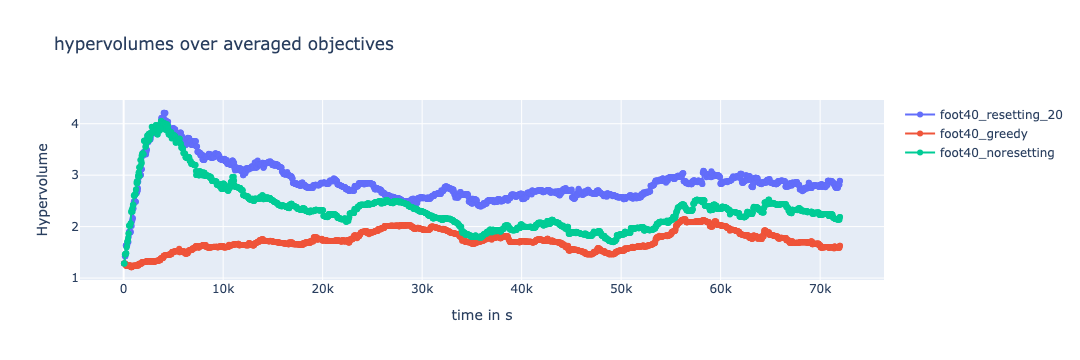

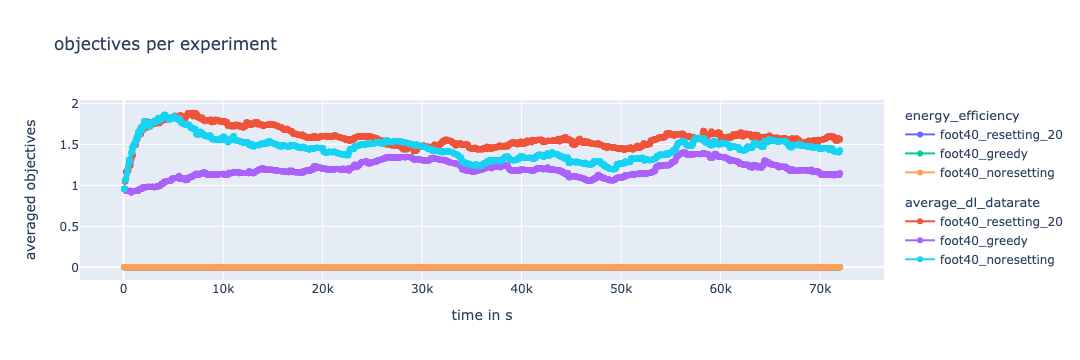

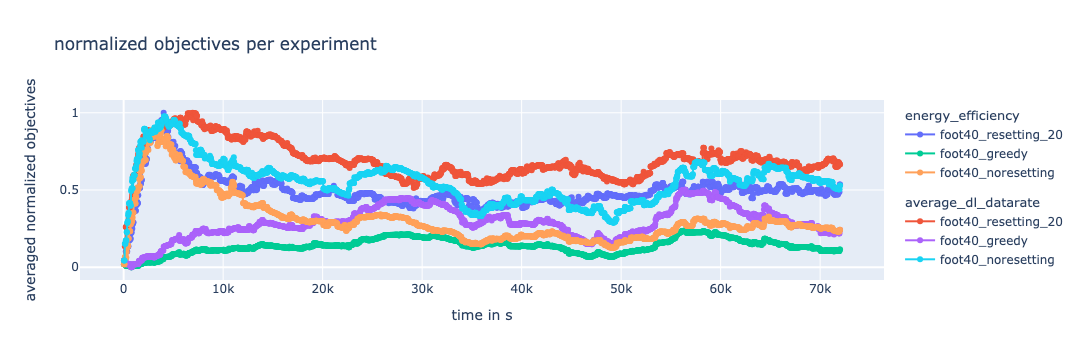

In [5]:
##################
# plots for comparing experiments
##################

## hyper volume plot


fig1 = go.Figure()
fig1.update_layout(
    title="hypervolumes over averaged objectives",
    xaxis_title="time in s",
    yaxis_title="Hypervolume")


## add experiment hypervolumes 
for index, value in enumerate(hypervolume_list):
    fig1.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=value,
            mode='lines+markers',
            name= f"{str(configuration_names[index])}",
        ))


## objective volume plot
fig2 = go.Figure()

fig2.update_layout(
    title= "objectives per experiment",
    xaxis_title="time in s",
    yaxis_title="averaged objectives"
    )
for index, _ in enumerate(objective_1_list):
    fig2.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_1_list[index],
            name=str(configuration_names[index]),
            mode='lines+markers',
            legendgroup="energy_efficiency",
            legendgrouptitle_text="energy_efficiency"
        ))
    fig2.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_2_list[index],
            name=str(configuration_names[index]),
            mode='lines+markers',
            legendgroup="average_dl_datarate",
            legendgrouptitle_text="average_dl_datarate"
        ))


## normalized objective plot

fig3 = go.Figure()

fig3.update_layout(
    title= "normalized objectives per experiment",
    xaxis_title="time in s",
    yaxis_title="averaged normalized objectives"
    )

for index, _ in enumerate(objective_1_normalized_list):
    fig3.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_1_normalized_list[index],
            name=str(configuration_names[index]),
            mode='lines+markers',
            legendgroup="energy_efficiency",
            legendgrouptitle_text="energy_efficiency"
        ))
    fig3.add_trace(
        go.Scatter(
            x=time_and_frames_list[:, 1],
            y=objective_2_normalized_list[index],
            name=str(configuration_names[index]),
            mode='lines+markers',
            legendgroup="average_dl_datarate",
            legendgrouptitle_text="average_dl_datarate"
        ))

fig1.show()
fig2.show()
fig3.show()